# FIR Filter on FPGA

## Import libraries

In [1]:
from pynq import Overlay, allocate
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import time
from typing import Tuple, Optional

## Generate test signal with 2 frequencies

This function generates a test signal combining two sine waves:

1. Main signal components:
   - Low frequency: 5 Hz sine wave with amplitude 1.0
   - High frequency: 50 Hz sine wave with amplitude 0.5

2. Key parameters:
   - `num_samples`: Number of samples in signal (default 100)
   - `sample_rate`: Sampling rate in Hz (default 1000 Hz)
   - Time array `t`: Goes from 0 to num_samples/sample_rate seconds

3. Return values:
   - `test_signal`: Combined waveform
   - `t`: Time points array

The signal is useful for testing frequency-based operations like filtering, as it contains both low and high frequency components with different amplitudes.

Would you like to see how this signal looks or explore how changing the parameters affects it?

In [2]:
def generate_test_signal(num_samples: int = 100, 
                        sample_rate: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate a test signal containing multiple frequencies
    """
    t = np.linspace(0, num_samples/sample_rate, num_samples)
    
    # Create signal with multiple frequency components
    low_freq = 5   # 5 Hz
    high_freq = 50 # 50 Hz
    
    test_signal = np.sin(2 * np.pi * low_freq * t) + \
                 0.5 * np.sin(2 * np.pi * high_freq * t)
    
    return test_signal, t

## Generate FIR low-pass filter co-efficients 

This function generates low-pass FIR filter coefficients for digital filtering:

1. Input parameters:
   - `cutoff_hz`: Cutoff frequency in Hz
   - `sample_rate`: Sampling rate in Hz
   - `num_taps`: Filter length (default 99)

2. Key steps:
   - Calculates Nyquist rate (sample_rate/2)
   - Normalizes cutoff frequency to [0,1] range
   - Uses firwin() to generate Hamming-windowed coefficients
   - Normalizes coefficients to sum to 1
   - Scales to int32 range using 2^15 factor to prevent overflow

3. Returns coefficients as int32 array suitable for hardware implementation.

Note: Using 2^15 instead of 2^31 prevents overflow during multiplication in the filter operation.

In [3]:
def generate_lowpass_coeffs(cutoff_hz: float, 
                          sample_rate: float, 
                          num_taps: int = 99) -> np.ndarray:
    """
    Generate low-pass FIR filter coefficients as int32
    """
    nyq_rate = sample_rate / 2.0
    cutoff_normalized = cutoff_hz / nyq_rate
    
    # Generate filter coefficients
    h = signal.firwin(num_taps, cutoff_normalized, window='hamming')
    
    # Normalize coefficients to sum to 1
    h = h / np.sum(np.abs(h))
    
    # Scale to int32 range while preserving relative values
    scale_factor = 2**15  # Using smaller scale factor to prevent overflow
    h_scaled = np.round(h * scale_factor).astype(np.int32)
    
    return h_scaled

## Function to run FIR on FPGA

This function implements FIR filtering on FPGA hardware. Key components:

1. Hardware Setup:
   - Loads FPGA bitstream
   - Gets FIR IP core instance

2. Signal Processing:
   - Scales input signal to int32 range (×2^15)
   - Allocates memory for input, output, and coefficients
   - Copies data to FPGA memory

3. IP Configuration:
   - Sets memory addresses (0x1c, 0x10, 0x30)
   - Sets sample length (0x28)
   - Starts processing (0x00)

4. Output Handling:
   - Waits for completion with 5s timeout
   - Rescales output back to float (÷(2^15)^2)
   - Handles errors with try/except

The double scaling division (output_scale) accounts for multiplication of two scaled int32 values (input signal × coefficients).

In [4]:
def process_with_fir(signal_in: np.ndarray, 
                   fir_coeffs: np.ndarray, 
                   bitstream_path: str = "fir_opt.bit") -> np.ndarray:
   """
   Process signal with FIR filter on FPGA
   """
   try:
       # Load the overlay
       overlay = Overlay(bitstream_path)
       
       # Get FIR IP
       fir = overlay.fir_opt_0
       
       # Scale input signal to use most of int32 range
       scale_factor = 2**15
       signal_int32 = np.round(signal_in * scale_factor).astype(np.int32)
       
       # Print debug info
       print("Input signal range:", np.min(signal_int32), "to", np.max(signal_int32))
       print("Coefficient range:", np.min(fir_coeffs), "to", np.max(fir_coeffs))
       
       # Memory allocation
       sample_len = len(signal_int32)
       coeff_len = len(fir_coeffs)
       
       input_buffer = allocate(shape=(sample_len,), dtype=np.int32)
       output_buffer = allocate(shape=(sample_len,), dtype=np.int32)
       coef_buffer = allocate(shape=(coeff_len,), dtype=np.int32)
       
       # Copy data to memory
       np.copyto(input_buffer, signal_int32)
       np.copyto(coef_buffer, fir_coeffs)
       
       # Configure IP
       fir.write(0x1c, input_buffer.physical_address)
       fir.write(0x10, output_buffer.physical_address)
       fir.write(0x30, coef_buffer.physical_address)
       fir.write(0x28, sample_len)
       
       # Start IP and wait for completion
       fir.write(0x00, 0x01)
       
       # Add timeout to prevent infinite loop
       timeout = time.time() + 5.0  # 5 second timeout
       while True:
           reg = fir.read(0x00)
           if reg != 1:
               break
           if time.time() > timeout:
               raise TimeoutError("FIR processing timeout")
       
       # Print raw output info before scaling
       raw_output = np.array(output_buffer)
       print("Raw output range:", np.min(raw_output), "to", np.max(raw_output))
       
       # Convert output back to float considering both scalings
       output_scale = scale_factor * scale_factor  # Account for both input and coefficient scaling
       output_float = output_buffer.astype(np.float64) / output_scale
       
       # Print final scaled output range
       print("Final output range:", np.min(output_float), "to", np.max(output_float))
       
       return output_float
       
   except Exception as e:
       print(f"Error processing FIR filter: {str(e)}")
       raise

## Function to plot waveforms in time and frequency domains

This function visualizes original and filtered signals in both time and frequency domains:

1. Time Domain Plot (Top):
   - X-axis: Time in seconds
   - Y-axis: Signal amplitude
   - Shows both original and filtered signals overlaid

2. Frequency Domain Plot (Bottom):
   - Uses FFT to convert signals to frequency domain
   - X-axis: Frequency in Hz
   - Y-axis: Magnitude
   - Shows only positive frequencies (mask = freqs_orig >= 0)
   - Helps visualize filter's effect on frequency components

The plots share a 15x10 figure with tight_layout() for proper spacing.

In [5]:
def plot_signals(original: np.ndarray, 
                filtered: np.ndarray, 
                t: np.ndarray, 
                sample_rate: float) -> None:
    """
    Plot original and filtered signals in time and frequency domains
    """
    plt.figure(figsize=(15, 10))
    
    # Time domain
    plt.subplot(2, 1, 1)
    plt.plot(t, original, label='Original')
    plt.plot(t, filtered, label='Filtered', alpha=0.7)
    plt.title('Time Domain Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    
    # Frequency domain
    plt.subplot(2, 1, 2)
    freqs_orig = np.fft.fftfreq(len(original), 1/sample_rate)
    fft_orig = np.abs(np.fft.fft(original))
    freqs_filt = np.fft.fftfreq(len(filtered), 1/sample_rate)
    fft_filt = np.abs(np.fft.fft(filtered))
    
    # Only plot positive frequencies
    mask = freqs_orig >= 0
    plt.plot(freqs_orig[mask], fft_orig[mask], label='Original')
    plt.plot(freqs_filt[mask], fft_filt[mask], label='Filtered', alpha=0.7)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Results

Input signal range: -48754 to 48754
Coefficient range: 1 to 785
Raw output range: -948037074 to 948037074
Final output range: -0.8829283285886049 to 0.8829283285886049


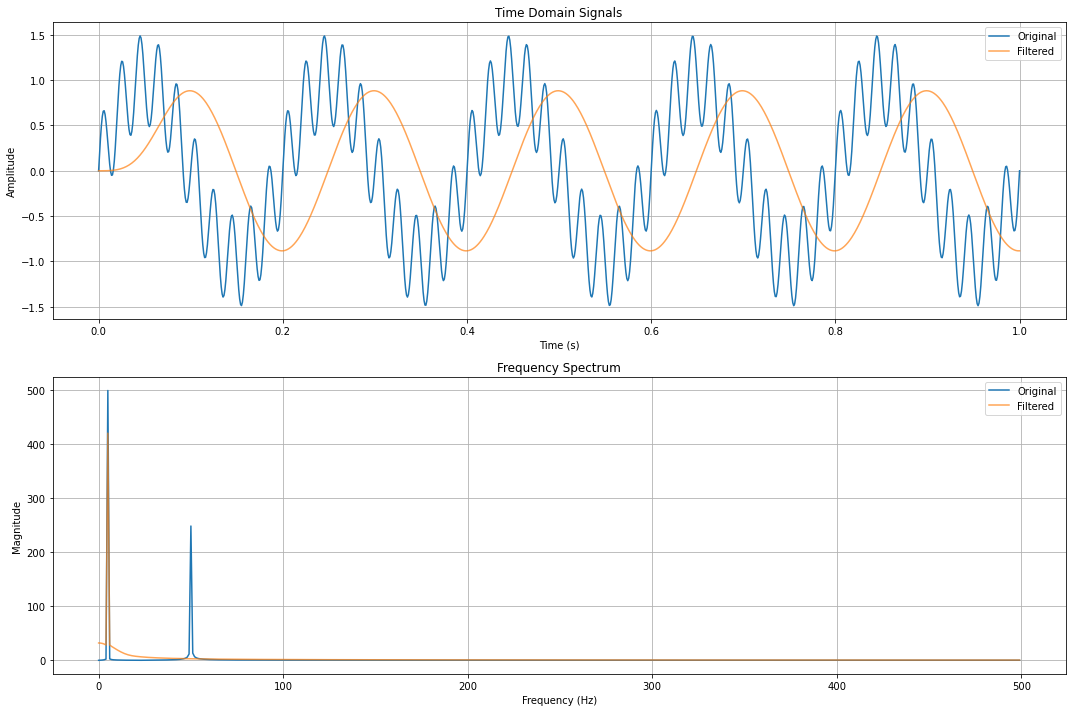

In [6]:
# Generate test signal
test_signal, time_array = generate_test_signal(num_samples=1000, sample_rate=1000)

# Generate filter coefficients
fir_coeffs = generate_lowpass_coeffs(cutoff_hz=10, sample_rate=1000)

# Process signal
filtered_signal = process_with_fir(test_signal, fir_coeffs)

# Plot results
plot_signals(test_signal, filtered_signal, time_array, 1000)

The plots show the results of a low-pass FIR filter:

Time Domain:
- Blue (original): Combined 5Hz and 50Hz signals
- Orange (filtered): Only 5Hz component remains
- Noticeable delay between original and filtered signals due to FIR filter delay of (N-1)/2 samples, where N is filter length

Frequency Domain:
- Two clear peaks in original signal: 5Hz (~500 magnitude) and 50Hz (~250 magnitude)
- Filtered signal shows only 5Hz peak, confirming successful low-frequency preservation
- High-frequency 50Hz component effectively removed

The delay is expected behavior for causal FIR filters and could be compensated if needed by shifting the filtered signal back by (filter_length-1)/2 samples.